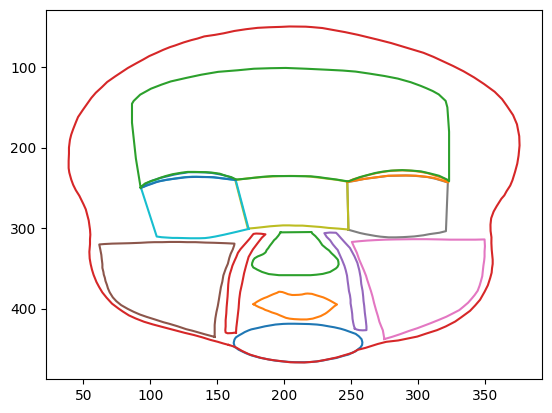

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

def convert_coord(coord_str):
    parts = coord_str.split(',')
    if len(parts) == 1:
        return float(parts[0])
    elif len(parts) == 2:
        return float(parts[0] + '.' + parts[1])
    else:
        raise ValueError('Invalid coordinate: ' + coord_str)

aoi = {}

with open('face_All_AOIs.txt', 'r') as f:
    current_aoi = None
    for line in f:
        line = line.strip()
        if line.startswith('AOI name:'):
            current_aoi = line.split(':')[1].strip()
            aoi[current_aoi] = {'X': [], 'Y': []}
        elif line.startswith('X'):
            continue
        elif current_aoi is not None:
            xy_match = re.match(r'^(\d+)(,\d+)?\s+(\d+)(,\d+)?$', line)
            if xy_match:
                x = convert_coord(xy_match.group(1) + (xy_match.group(2) or ''))
                y = convert_coord(xy_match.group(3) + (xy_match.group(4) or ''))
                aoi[current_aoi]['X'].append(x)
                aoi[current_aoi]['Y'].append(y)
area = {}
# exibir o dicionário resultante
for k in aoi.keys():
    aoi[k]['X'].append(aoi[k]['X'][0])
    aoi[k]['Y'].append(aoi[k]['Y'][0])
    
    x, y = aoi[k]['X'], aoi[k]['Y']
    plt.plot(x, y)
    
    points = list(zip(x, y))
    hull = ConvexHull(points)
    area[k] = hull.area

plt.gca().invert_yaxis()
face = aoi.pop('Face')
area_face = area.pop('Face')

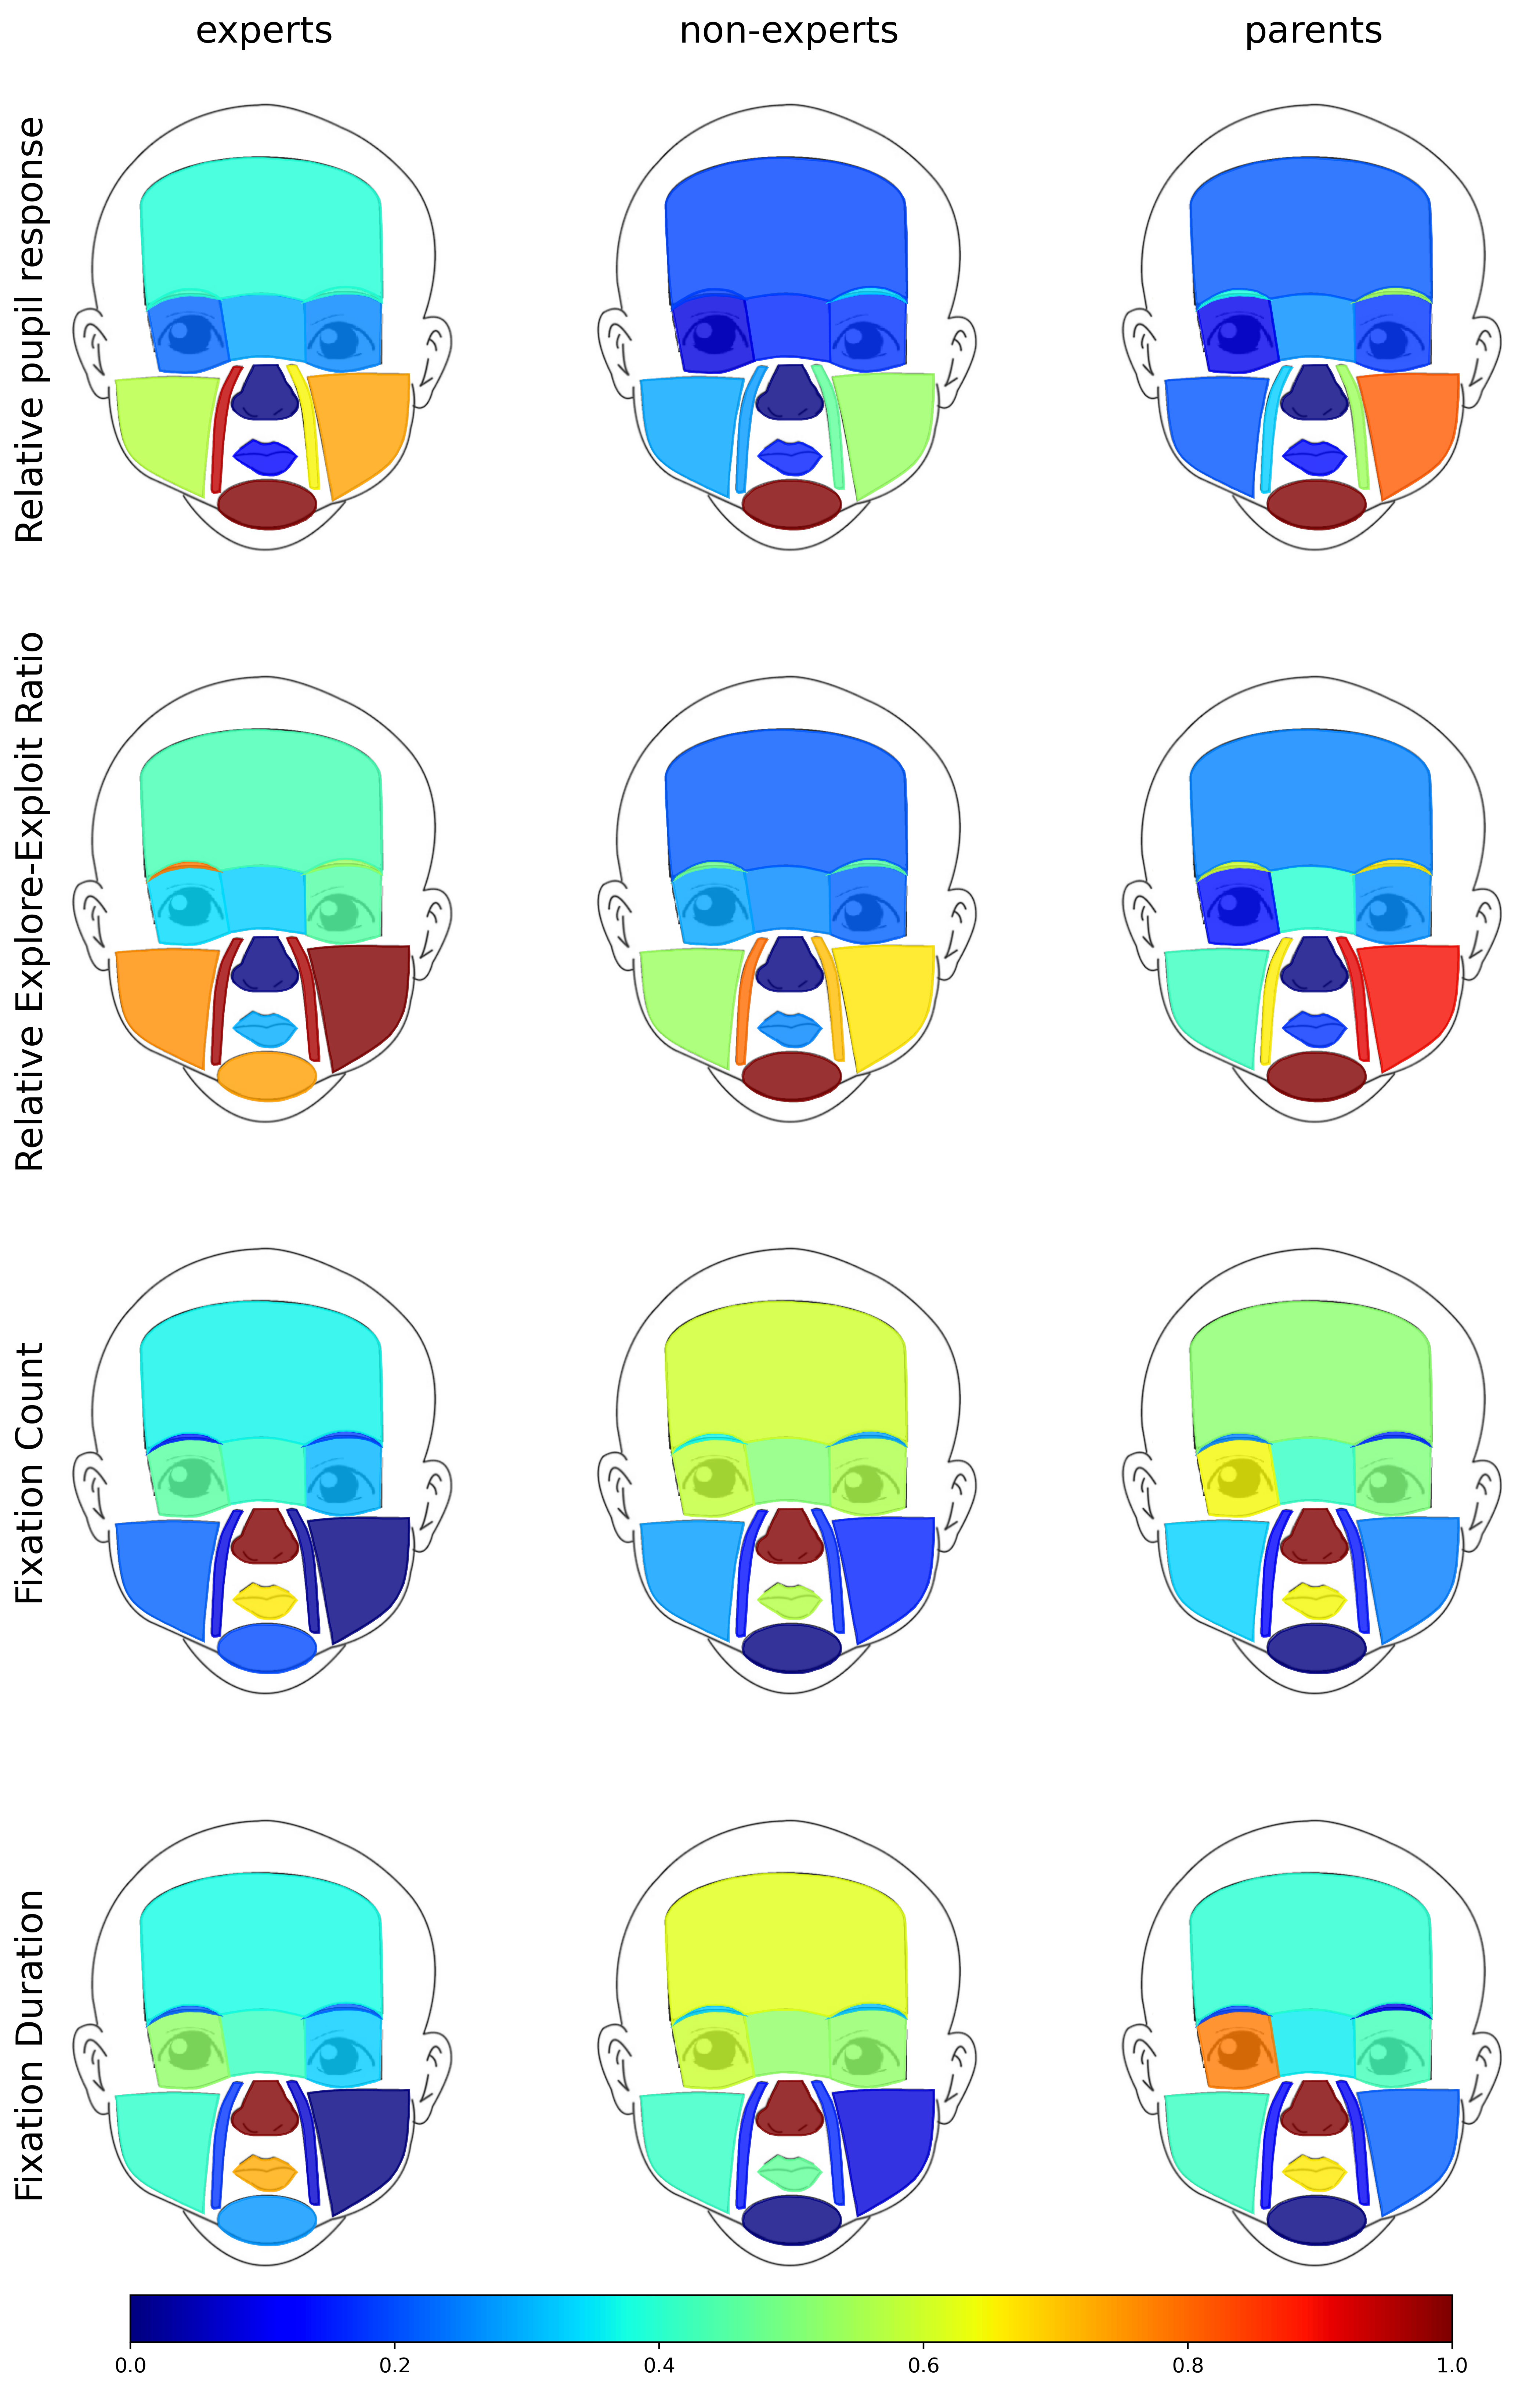

In [2]:
from optparse import Values
import pandas as pd
import numpy as np
from matplotlib.image import imread
import matplotlib.colors as mcolors

cmap = plt.get_cmap('jet')
groups = ['doctors','non-experts','parents']
glabel = ['experts','non-experts','parents']

metrics = ['relative_pupil_diameter','ee_ratio','count_fixation','GazeEventDuration']
mlabel = ['Relative pupil response','Relative Explore-Exploit Ratio','Fixation Count', 'Fixation Duration']


raw_data = pd.read_csv('aoi_pupil_1.csv', index_col=1)
# raw_data = raw_data[raw_data['GazeEventDuration']>0]
raw_data['AOI'] = raw_data['AOI'].replace('Sulco Nasolabial E.','Sulco Nasolabial E')
raw_data['AOI'] = raw_data['AOI'].replace('Sulco Nasolabial D.','Sulco Nasolabial D')
raw_data['GazeEventDuration'] = raw_data['fixation_duration']+raw_data['saccade_duration']

raw_data['relative_pupil_diameter'] = raw_data['pupil_diameter']/raw_data['GazeEventDuration']
raw_data['ee_ratio'] = raw_data['ee_ratio']/raw_data['GazeEventDuration']

mgd_data = raw_data.groupby(['participant_group','AOI'])[['relative_pupil_diameter','count_fixation','GazeEventDuration','ee_ratio']].mean()

# for g, gdata in mgd_data:
    
fig, axs = plt.subplots(4, 3, figsize=(18, 16), dpi=400)
img = imread('Face_2.png')

for i,m in enumerate(metrics):
    for j,g in enumerate(groups): 
        values = mgd_data.loc[g][m]
        norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
        for k, key in enumerate(aoi):
            x_coords = aoi[key]['X']
            y_coords = aoi[key]['Y']

            color = cmap(norm(values.loc[key]))
            axs[i,j].fill(x_coords, y_coords, color=color, alpha=0.8)

        if i == 0:
            axs[i,j].set_title(glabel[j], fontsize=18)

        axs[i,j].set_aspect('equal')
        axs[i, j].set_xticks([])  # Remover ticks do eixo x
        axs[i, j].set_yticks([]) 

        # Remover as spines (o quadro) do plot
        axs[i, j].spines['top'].set_visible(False)
        axs[i, j].spines['right'].set_visible(False)
        axs[i, j].spines['bottom'].set_visible(False)
        axs[i, j].spines['left'].set_visible(False)

        axs[i,j].imshow(img, alpha=1)

        if j == 0:
            axs[i, j].set_ylabel(mlabel[i], fontsize=18, rotation=90, labelpad=10, ha='center', va='center')
        plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
# fig.colorbar(sm)
fig.subplots_adjust(right=0.75)
cbar_ax = fig.add_axes([0.13, 0, 0.5, 0.02])
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='horizontal', shrink=0.5, cax=cbar_ax)
cbar.ax.tick_params(labelsize=10)
# plt.tight_layout()
# fig.suptitle(f'{classe}\n', fontsize=16)

plt.show()